In [328]:
# Importing Important Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from catboost import CatBoostClassifier
 

# For test train split
from sklearn.model_selection import train_test_split,cross_val_score

# For feature scaling
from sklearn.preprocessing import StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# For logistic regression
import statsmodels.api as sm

from xgboost import XGBClassifier

#Scorer
from sklearn.metrics import make_scorer

# For RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics

# To check the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import precision_score, recall_score,roc_auc_score,f1_score
from sklearn.metrics import precision_recall_curve

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [329]:
# Read Files
train_data_raw = pd.read_csv('train.csv')
train_data_raw.head()

,id,program_id,program_type,program_duration,test_id,test_type,difficulty_level,invigilator,gender,education,city_tier,age,total_programs_enrolled,is_handicapped,invigilator_engagement_rating,is_pass
0,9389_150,Y_1,Y,136,150,offline,intermediate,9389,M,High school (10th grade),3,24.0,5,N,1.0,0
1,16523_44,T_1,T,131,44,offline,easy,16523,F,High School (12th grade),4,26.0,2,N,3.0,1
2,13987_178,Z_2,Z,120,178,online,easy,13987,M,High school (10th grade),1,40.0,1,N,2.0,1
3,13158_32,T_2,T,117,32,offline,easy,13158,F,High school (10th grade),3,NaN,4,N,1.0,1
4,10591_84,V_3,V,131,84,offline,intermediate,10591,F,High School (12th grade),1,42.0,2,N,4.0,1


In [330]:
print(train_data_raw.shape)
train_data_raw.info()

(73147, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73147 entries, 0 to 73146
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             73147 non-null  object 
 1   program_id                     73147 non-null  object 
 2   program_type                   73147 non-null  object 
 3   program_duration               73147 non-null  int64  
 4   test_id                        73147 non-null  int64  
 5   test_type                      73147 non-null  object 
 6   difficulty_level               73147 non-null  object 
 7   invigilator                    73147 non-null  int64  
 8   gender                         73147 non-null  object 
 9   education                      73147 non-null  object 
 10  city_tier                      73147 non-null  int64  
 11  age                            45418 non-null  float64
 12  total_programs_enrolled        731

In [331]:
# Null value treatment for age and invigilator_engagement_rating
print(train_data_raw['age'].isnull().sum()/len(train_data_raw))
print(train_data_raw['invigilator_engagement_rating'].isnull().sum()/len(train_data_raw))
# Remove age variable and impute invigilator_engagement_rating with its mode value

0.3790859502098514
0.0010526747508441904


In [332]:
# Split the data into test and train
Y_raw = train_data_raw['is_pass']
X_raw = train_data_raw.drop('is_pass',axis = 1)
train_x,test_x,train_y,test_y = train_test_split(X_raw,Y_raw,test_size = 0.20,random_state = 100)

train_data = pd.concat([train_x,train_y],axis = 1).reset_index(drop = True)
test_data = pd.concat([test_x,test_y],axis = 1).reset_index(drop = True)

print(train_data.shape)
print(test_data.shape)

(58517, 16)
(14630, 16)


In [333]:
# Function to plot boxplot for univariate analysis
sns.set_theme(style="whitegrid")
def univariate_box_plot(series):
    sns.boxplot(y = series,palette="Set3")
    
# Function to plot pairwise boxplot-Variable vs outcome
def pairwise_box_plot(series1,series2):
    sns.boxplot(x = series1,y = series2,palette="Set3")
    
# Function for Outlier Treatment, Return the upper cutoff and the lower cutoff
def upper_lower_wisker(series):
    median = np.percentile(series,50)
    lower_quartile = np.percentile(series,25)
    upper_quartile = np.percentile(series,75)
    IQR = upper_quartile - lower_quartile
    lower_wisker = lower_quartile  - 1.5*IQR
    upper_wisker = upper_quartile + 1.5*IQR
    return (upper_wisker,lower_wisker)

#Function to plot distplot
def univariate_dist_plot(series):
    sns.distplot(series,bins = 20)
    
# Function to plot Scatterplot
def univariate_scatter_plot(x,y):
    sns.scatterplot(x,y,palette = "Set3")
    
# Function to plot barplot
def univariate_bar_plot(x,y):
    sns.barplot(x,y)
    

In [334]:
# Process Each Element
#test_type
train_data['test_type'].value_counts()/len((train_data))

offline    0.595639
online     0.404361
Name: test_type, dtype: float64

In [335]:
#program_id

def program_func(x):
    if(int(x.split('_')[1])==1):
        return 1
    elif(int(x.split('_')[1])==2):
        return 2
    elif(int(x.split('_')[1])==3):
        return 3
    else:
        return 4

train_data['program_id'].value_counts()/len((train_data))
# Since there are lot of categories, lets club it as 1,2,3,4
train_data['program_id']  = train_data['program_id'].apply(lambda x:program_func(x))
train_data['program_id'].value_counts()/len((train_data))

1    0.298648
3    0.275014
2    0.232086
4    0.194251
Name: program_id, dtype: float64

In [336]:
#program_type
train_data['program_type'].value_counts()/len((train_data))

Y    0.308868
T    0.252029
V    0.177008
U    0.106414
Z    0.091170
X    0.046277
S    0.018234
Name: program_type, dtype: float64

In [337]:
#test_id
train_data['test_id'].value_counts()/len((train_data))
# Remove this feature from analysis

149    0.011040
61     0.010646
21     0.010407
43     0.010202
125    0.009946
126    0.009792
150    0.009262
80     0.009057
27     0.008733
44     0.008681
62     0.008664
22     0.008493
45     0.008408
57     0.008186
154    0.008151
131    0.008134
113    0.008117
127    0.008049
23     0.008049
130    0.007929
46     0.007895
94     0.007878
10     0.007861
29     0.007827
95     0.007758
155    0.007741
114    0.007622
28     0.007605
47     0.007605
151    0.007605
128    0.007468
81     0.007468
96     0.007229
24     0.007212
16     0.007126
63     0.007041
65     0.007024
52     0.007024
11     0.006972
156    0.006972
159    0.006938
152    0.006938
137    0.006921
25     0.006904
82     0.006887
158    0.006870
30     0.006819
132    0.006767
134    0.006767
160    0.006767
31     0.006750
97     0.006716
135    0.006682
157    0.006631
129    0.006596
32     0.006562
133    0.006528
118    0.006477
33     0.006391
58     0.006391
12     0.006357
136    0.006357
83     0

In [338]:
#difficulty_level
train_data['difficulty_level'].value_counts()/len((train_data))

easy            0.547157
intermediate    0.282943
hard            0.141138
vary hard       0.028761
Name: difficulty_level, dtype: float64

In [339]:
#invigilator
train_data['invigilator'].value_counts()/len((train_data))
# Remove this feature from analysis

5893     0.000256
3837     0.000256
6324     0.000256
7270     0.000222
2535     0.000222
           ...   
10339    0.000017
4314     0.000017
15657    0.000017
3375     0.000017
18076    0.000017
Name: invigilator, Length: 17774, dtype: float64

In [340]:
#gender
train_data['gender'].value_counts()/len((train_data))

M    0.535161
F    0.464839
Name: gender, dtype: float64

In [341]:
#education
def education_func(x):
    if('high school' in x.lower()):
        return 'High_School'
    elif('Bachelor' in x):
        return 'Bachelor'
    else:
        return 'Others'
train_data['education'].value_counts()/len((train_data))
# club education into 3 categories only
train_data['education'] = train_data['education'].apply(lambda x:education_func(x))
train_data['education'].value_counts()/len((train_data))

High_School    0.827657
Bachelor       0.158484
Others         0.013859
Name: education, dtype: float64

In [342]:
#city_tier
train_data['city_tier'].value_counts()/len((train_data))

3    0.357588
1    0.317463
2    0.222927
4    0.102022
Name: city_tier, dtype: float64

In [343]:
#total_programs_enrolled
train_data['total_programs_enrolled'].value_counts()/len((train_data))

2     0.555480
4     0.183571
3     0.104534
1     0.103201
5     0.023309
6     0.019687
8     0.004136
7     0.003794
9     0.001025
12    0.000410
10    0.000410
11    0.000239
14    0.000205
Name: total_programs_enrolled, dtype: float64

In [344]:
#invigilator_engagement_rating
train_data['invigilator_engagement_rating'] = train_data['invigilator_engagement_rating'].fillna(1)
train_data['invigilator_engagement_rating'].value_counts()/len((train_data))


1.0    0.351112
2.0    0.235248
4.0    0.179367
3.0    0.158347
5.0    0.075927
Name: invigilator_engagement_rating, dtype: float64

In [345]:
#is_handicapped
train_data['is_handicapped'].value_counts()/len((train_data))

N    0.909838
Y    0.090162
Name: is_handicapped, dtype: float64

<AxesSubplot:ylabel='program_duration'>

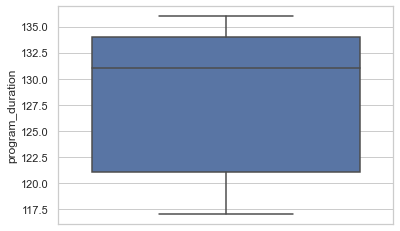

In [346]:
sns.boxplot(y = train_data['program_duration'])
# No outliers

In [347]:
#is_pass
train_data['is_pass'].value_counts()/len((train_data))
# Data Is Skewed, we need to balance it using class weights

1    0.695131
0    0.304869
Name: is_pass, dtype: float64

In [348]:
# Select final variables for model selection
X_Train = train_data[['program_id','program_type','program_duration','test_type','difficulty_level','gender','education','city_tier','total_programs_enrolled','is_handicapped','invigilator_engagement_rating']]
Y_Train = train_data['is_pass']

In [349]:
# Creating dummy for categorical variables
# Converting into dummy variables for categorical varibales with more than 2 unique values
dummy_list = ['program_id','program_type','test_type','difficulty_level','gender','education','city_tier','is_handicapped']
dummy_var = pd.get_dummies(X_Train[dummy_list], drop_first = True)

# Adding to dataframe
X_Train = pd.concat([X_Train, dummy_var], axis=1).reset_index(drop = True)
X_Train.drop(dummy_list, axis = 1, inplace =  True)
print(X_Train.shape)
X_Train.head()

(58517, 17)


,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,130,5,2.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,134,2,2.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,120,2,3.0,0,0,0,0,1,0,0,1,0,0,1,1,0,0
3,134,2,1.0,1,0,0,0,0,0,0,0,1,0,1,1,0,0
4,136,2,4.0,0,0,0,0,1,0,0,1,0,0,1,1,0,0


In [350]:
scaler = MinMaxScaler()
num_cols = ['program_duration','total_programs_enrolled','invigilator_engagement_rating']

X_Train[num_cols] = scaler.fit_transform(X_Train[num_cols])
X_Train.head()

,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,0.684211,0.307692,0.25,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.894737,0.076923,0.25,0,1,0,0,0,0,1,0,0,0,0,0,0,0
2,0.157895,0.076923,0.50,0,0,0,0,1,0,0,1,0,0,1,1,0,0
3,0.894737,0.076923,0.00,1,0,0,0,0,0,0,0,1,0,1,1,0,0
4,1.000000,0.076923,0.75,0,0,0,0,1,0,0,1,0,0,1,1,0,0


In [351]:
# Model Building Starts
# Functions to find confusion metrics and F1 Score
# Confusion matrix 

def confusion_matrix_func(predicted,actual,cutoff):
    predicted = np.where(predicted>cutoff,1,0)
    confusion_matrix = metrics.confusion_matrix(actual, predicted )
    print(confusion_matrix)

    # Checking other metrics
    TP = confusion_matrix[1,1] # true positive 
    TN = confusion_matrix[0,0] # true negatives
    FP = confusion_matrix[0,1] # false positives
    FN = confusion_matrix[1,0] # false negatives

    # Checking the overall accuracy.
    print("Accuracy: ",metrics.accuracy_score(actual, predicted))
    # Checking the sensitivity of the model
#     print("Sensitivity: ",TP / float(TP+FN))
#     # Calculating specificity
#     print("Specificity: ",TN / float(TN+FP))
#     # Calculating false postive rate - predicting converted rate when lead actually did not get converted
#     print("False Positive Rate: ",FP/ float(TN+FP))
#     # Calculating positive predictive value 
#     print ("Positive Predictive Value: ",TP / float(TP+FP))
#     # Calculating negative predictive value
#     print ("Negative Predictive Value: ",TN / float(TN+ FN))
#     #AUC Score
#     print("ROC_AUC_Score:",roc_auc_score(actual,predicted))
    #Recall Score
    print("Recall_Score:",recall_score(actual,predicted))
    #Precsion Score
    print("Precision_Score:",precision_score(actual,predicted))
    #F1 Score
    print("F1 Score",(f1_score(actual,predicted,average = 'weighted')))

In [352]:
# F1 Score Optimisation

def f1_score_optimisation(predicted,actual):
    cutoff  = np.arange(0,1,0.05)
    f1_list = []
    for c in cutoff:
        predicted_binary = np.where(predicted>c,1,0)
        f1_list.append((f1_score(actual,predicted_binary),c))
    return max(f1_list)

In [353]:
cb = CatBoostClassifier()
cb.fit(X_Train,Y_Train)
predicted = cb.predict_proba(X_Train)[:,1]
cb_best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = cb_best_cutoff[1])
print(cb_best_cutoff[1])

Learning rate set to 0.058555
0:	learn: 0.6787229	total: 215ms	remaining: 3m 34s
1:	learn: 0.6657146	total: 232ms	remaining: 1m 55s
2:	learn: 0.6545834	total: 255ms	remaining: 1m 24s
3:	learn: 0.6440454	total: 301ms	remaining: 1m 14s
4:	learn: 0.6365605	total: 332ms	remaining: 1m 5s
5:	learn: 0.6279998	total: 380ms	remaining: 1m 2s
6:	learn: 0.6210648	total: 411ms	remaining: 58.2s
7:	learn: 0.6148131	total: 435ms	remaining: 54s
8:	learn: 0.6093923	total: 454ms	remaining: 50s
9:	learn: 0.6046809	total: 473ms	remaining: 46.9s
10:	learn: 0.6002731	total: 504ms	remaining: 45.3s
11:	learn: 0.5962469	total: 540ms	remaining: 44.4s
12:	learn: 0.5932126	total: 571ms	remaining: 43.3s
13:	learn: 0.5901072	total: 597ms	remaining: 42s
14:	learn: 0.5876849	total: 621ms	remaining: 40.8s
15:	learn: 0.5848139	total: 637ms	remaining: 39.2s
16:	learn: 0.5828181	total: 657ms	remaining: 38s
17:	learn: 0.5806868	total: 685ms	remaining: 37.4s
18:	learn: 0.5790489	total: 710ms	remaining: 36.7s
19:	learn: 0.57

166:	learn: 0.5480974	total: 4.91s	remaining: 24.5s
167:	learn: 0.5480231	total: 4.93s	remaining: 24.4s
168:	learn: 0.5479828	total: 4.96s	remaining: 24.4s
169:	learn: 0.5479445	total: 4.98s	remaining: 24.3s
170:	learn: 0.5479000	total: 5.02s	remaining: 24.3s
171:	learn: 0.5478484	total: 5.04s	remaining: 24.2s
172:	learn: 0.5477994	total: 5.07s	remaining: 24.2s
173:	learn: 0.5477446	total: 5.09s	remaining: 24.2s
174:	learn: 0.5476927	total: 5.12s	remaining: 24.2s
175:	learn: 0.5476295	total: 5.15s	remaining: 24.1s
176:	learn: 0.5475872	total: 5.17s	remaining: 24.1s
177:	learn: 0.5475298	total: 5.21s	remaining: 24.1s
178:	learn: 0.5474690	total: 5.24s	remaining: 24s
179:	learn: 0.5473977	total: 5.27s	remaining: 24s
180:	learn: 0.5473139	total: 5.31s	remaining: 24s
181:	learn: 0.5472710	total: 5.34s	remaining: 24s
182:	learn: 0.5472096	total: 5.37s	remaining: 24s
183:	learn: 0.5471701	total: 5.41s	remaining: 24s
184:	learn: 0.5471237	total: 5.43s	remaining: 23.9s
185:	learn: 0.5470528	to

325:	learn: 0.5414253	total: 9.47s	remaining: 19.6s
326:	learn: 0.5413880	total: 9.49s	remaining: 19.5s
327:	learn: 0.5413376	total: 9.52s	remaining: 19.5s
328:	learn: 0.5413002	total: 9.55s	remaining: 19.5s
329:	learn: 0.5412819	total: 9.59s	remaining: 19.5s
330:	learn: 0.5412423	total: 9.61s	remaining: 19.4s
331:	learn: 0.5412259	total: 9.64s	remaining: 19.4s
332:	learn: 0.5412174	total: 9.67s	remaining: 19.4s
333:	learn: 0.5411782	total: 9.7s	remaining: 19.3s
334:	learn: 0.5411469	total: 9.73s	remaining: 19.3s
335:	learn: 0.5411226	total: 9.75s	remaining: 19.3s
336:	learn: 0.5410872	total: 9.78s	remaining: 19.2s
337:	learn: 0.5410437	total: 9.8s	remaining: 19.2s
338:	learn: 0.5409998	total: 9.83s	remaining: 19.2s
339:	learn: 0.5409853	total: 9.85s	remaining: 19.1s
340:	learn: 0.5409486	total: 9.88s	remaining: 19.1s
341:	learn: 0.5409162	total: 9.92s	remaining: 19.1s
342:	learn: 0.5408798	total: 9.95s	remaining: 19.1s
343:	learn: 0.5408494	total: 9.98s	remaining: 19s
344:	learn: 0.54

488:	learn: 0.5371930	total: 13.9s	remaining: 14.5s
489:	learn: 0.5371667	total: 13.9s	remaining: 14.5s
490:	learn: 0.5371451	total: 13.9s	remaining: 14.4s
491:	learn: 0.5371160	total: 13.9s	remaining: 14.4s
492:	learn: 0.5371049	total: 14s	remaining: 14.4s
493:	learn: 0.5370898	total: 14s	remaining: 14.3s
494:	learn: 0.5370685	total: 14s	remaining: 14.3s
495:	learn: 0.5370410	total: 14.1s	remaining: 14.3s
496:	learn: 0.5370193	total: 14.1s	remaining: 14.3s
497:	learn: 0.5369985	total: 14.1s	remaining: 14.2s
498:	learn: 0.5369847	total: 14.2s	remaining: 14.2s
499:	learn: 0.5369485	total: 14.2s	remaining: 14.2s
500:	learn: 0.5369275	total: 14.3s	remaining: 14.2s
501:	learn: 0.5369087	total: 14.3s	remaining: 14.2s
502:	learn: 0.5368927	total: 14.3s	remaining: 14.1s
503:	learn: 0.5368851	total: 14.4s	remaining: 14.1s
504:	learn: 0.5368716	total: 14.4s	remaining: 14.1s
505:	learn: 0.5368349	total: 14.4s	remaining: 14.1s
506:	learn: 0.5368104	total: 14.5s	remaining: 14.1s
507:	learn: 0.5367

651:	learn: 0.5340364	total: 18.7s	remaining: 10s
652:	learn: 0.5340116	total: 18.8s	remaining: 9.97s
653:	learn: 0.5339903	total: 18.8s	remaining: 9.94s
654:	learn: 0.5339679	total: 18.8s	remaining: 9.91s
655:	learn: 0.5339528	total: 18.8s	remaining: 9.88s
656:	learn: 0.5339350	total: 18.9s	remaining: 9.85s
657:	learn: 0.5339181	total: 18.9s	remaining: 9.82s
658:	learn: 0.5339000	total: 18.9s	remaining: 9.79s
659:	learn: 0.5338710	total: 18.9s	remaining: 9.76s
660:	learn: 0.5338606	total: 19s	remaining: 9.73s
661:	learn: 0.5338472	total: 19s	remaining: 9.69s
662:	learn: 0.5338326	total: 19s	remaining: 9.66s
663:	learn: 0.5338023	total: 19s	remaining: 9.63s
664:	learn: 0.5337828	total: 19.1s	remaining: 9.6s
665:	learn: 0.5337388	total: 19.1s	remaining: 9.57s
666:	learn: 0.5337254	total: 19.1s	remaining: 9.54s
667:	learn: 0.5337145	total: 19.1s	remaining: 9.51s
668:	learn: 0.5337010	total: 19.2s	remaining: 9.48s
669:	learn: 0.5336854	total: 19.2s	remaining: 9.46s
670:	learn: 0.5336713	t

813:	learn: 0.5315527	total: 23.2s	remaining: 5.29s
814:	learn: 0.5315293	total: 23.2s	remaining: 5.26s
815:	learn: 0.5315136	total: 23.2s	remaining: 5.23s
816:	learn: 0.5315001	total: 23.2s	remaining: 5.2s
817:	learn: 0.5314797	total: 23.3s	remaining: 5.17s
818:	learn: 0.5314732	total: 23.3s	remaining: 5.15s
819:	learn: 0.5314502	total: 23.3s	remaining: 5.12s
820:	learn: 0.5314432	total: 23.3s	remaining: 5.09s
821:	learn: 0.5314322	total: 23.4s	remaining: 5.06s
822:	learn: 0.5314246	total: 23.4s	remaining: 5.03s
823:	learn: 0.5314118	total: 23.4s	remaining: 5s
824:	learn: 0.5314068	total: 23.5s	remaining: 4.98s
825:	learn: 0.5313822	total: 23.5s	remaining: 4.95s
826:	learn: 0.5313635	total: 23.5s	remaining: 4.92s
827:	learn: 0.5313635	total: 23.6s	remaining: 4.89s
828:	learn: 0.5313487	total: 23.6s	remaining: 4.86s
829:	learn: 0.5313469	total: 23.6s	remaining: 4.83s
830:	learn: 0.5313386	total: 23.6s	remaining: 4.81s
831:	learn: 0.5313323	total: 23.7s	remaining: 4.78s
832:	learn: 0.53

976:	learn: 0.5295389	total: 27.9s	remaining: 657ms
977:	learn: 0.5295116	total: 27.9s	remaining: 628ms
978:	learn: 0.5294926	total: 28s	remaining: 600ms
979:	learn: 0.5294805	total: 28s	remaining: 571ms
980:	learn: 0.5294627	total: 28s	remaining: 543ms
981:	learn: 0.5294554	total: 28.1s	remaining: 514ms
982:	learn: 0.5294357	total: 28.1s	remaining: 486ms
983:	learn: 0.5294228	total: 28.1s	remaining: 457ms
984:	learn: 0.5294068	total: 28.2s	remaining: 429ms
985:	learn: 0.5293915	total: 28.2s	remaining: 400ms
986:	learn: 0.5293855	total: 28.2s	remaining: 372ms
987:	learn: 0.5293766	total: 28.3s	remaining: 343ms
988:	learn: 0.5293643	total: 28.3s	remaining: 315ms
989:	learn: 0.5293497	total: 28.3s	remaining: 286ms
990:	learn: 0.5293331	total: 28.3s	remaining: 257ms
991:	learn: 0.5293182	total: 28.4s	remaining: 229ms
992:	learn: 0.5293025	total: 28.4s	remaining: 200ms
993:	learn: 0.5293003	total: 28.4s	remaining: 172ms
994:	learn: 0.5292848	total: 28.5s	remaining: 143ms
995:	learn: 0.5292

In [281]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_Train,Y_Train)
predicted = knn.predict_proba(X_Train)[:,1]

# F1 Optimisation
knn_best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = knn_best_cutoff[1])
print(knn_best_cutoff[1])

[[ 2432 15408]
 [ 1729 38948]]
Accuracy:  0.7071449322419127
Recall_Score: 0.9574944071588367
Precision_Score: 0.7165354330708661
F1 Score 0.6371811255144408
0.30000000000000004


In [282]:
# Logistic Regression
lr_model = LogisticRegression(random_state = 0,class_weight = 'balanced')
lr_model.fit(X_Train,Y_Train)
# Making predictions on train set
predicted = lr_model.predict_proba(X_Train)[:,1]

# F1 Optimisation
lr_best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = lr_best_cutoff[1])
print(lr_best_cutoff[1])

[[  492 17348]
 [  224 40453]]
Accuracy:  0.6997111950373396
Recall_Score: 0.9944932025468938
Precision_Score: 0.6998667843116901
F1 Score 0.5872617996473106
0.2


In [283]:
dt_model = DecisionTreeClassifier(random_state = 0,max_depth = 5,class_weight = 'balanced')
dt_model.fit(X_Train,Y_Train)
# Making predictions on train set
predicted = dt_model.predict_proba(X_Train)[:,1]

# F1 Optimisation
dt_best_cutoff = f1_score_optimisation(predicted,Y_Train)

# Calling confusion metrics on train data
confusion_matrix_func(predicted,Y_Train,cutoff = dt_best_cutoff[1])
print(dt_best_cutoff[1])

[[  365 17475]
 [  159 40518]]
Accuracy:  0.6986516738725499
Recall_Score: 0.9960911571649826
Precision_Score: 0.6986705292018002
F1 Score 0.5830186328885572
0.2


In [354]:
# Prepare test data
test_data['program_id']  = test_data['program_id'].apply(lambda x:program_func(x))
test_data['education'] = test_data['education'].apply(lambda x:education_func(x))
test_data['invigilator_engagement_rating'] = test_data['invigilator_engagement_rating'].fillna(1)

In [355]:
# Select final variables for model selection
X_Test = test_data[['program_id','program_type','program_duration','test_type','difficulty_level','gender','education','city_tier','total_programs_enrolled','is_handicapped','invigilator_engagement_rating']]
Y_Test = test_data['is_pass']

In [356]:
# Creating dummy for categorical variables
# Converting into dummy variables for categorical varibales with more than 2 unique values
dummy_list = ['program_id','program_type','test_type','difficulty_level','gender','education','city_tier','is_handicapped']
dummy_var = pd.get_dummies(X_Test[dummy_list], drop_first = True)

# Adding to dataframe
X_Test = pd.concat([X_Test, dummy_var], axis=1).reset_index(drop = True)
X_Test.drop(dummy_list, axis = 1, inplace =  True)
print(X_Test.shape)
X_Test.head()

(14630, 17)


,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,121,2,4.0,0,0,0,0,1,0,1,0,0,0,0,1,0,1
1,120,3,2.0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
2,135,3,5.0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
3,117,2,1.0,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,122,2,1.0,0,0,1,0,0,0,1,0,0,0,1,1,0,0


In [357]:
num_cols = ['program_duration','total_programs_enrolled','invigilator_engagement_rating']

X_Test[num_cols] = scaler.transform(X_Test[num_cols])
X_Test.head()

,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_hard,difficulty_level_intermediate,difficulty_level_vary hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,0.210526,0.076923,0.75,0,0,0,0,1,0,1,0,0,0,0,1,0,1
1,0.157895,0.153846,0.25,0,0,0,0,1,0,0,1,0,0,1,0,0,0
2,0.947368,0.153846,1.00,0,0,0,0,1,0,1,0,0,0,1,1,0,0
3,0.000000,0.076923,0.00,1,0,0,0,0,0,1,0,0,0,0,1,0,0
4,0.263158,0.076923,0.00,0,0,1,0,0,0,1,0,0,0,1,1,0,0


In [358]:
# Prediction using Logistic Regression

# Making predictions on test set
predicted = cb.predict_proba(X_Test)[:,1]

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = cb_best_cutoff[1])

[[ 873 3567]
 [ 551 9639]]
Accuracy:  0.7185235816814765
Recall_Score: 0.945927379784102
Precision_Score: 0.7298955020445252
F1 Score 0.664281138174061


In [288]:
# Prediction using Logistic Regression

# Making predictions on test set
predicted = lr_model.predict_proba(X_Test)[:,1]

# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = lr_best_cutoff[1])

[[  136  4304]
 [   49 10141]]
Accuracy:  0.7024606971975393
Recall_Score: 0.9951913640824338
Precision_Score: 0.7020422291450329
F1 Score 0.5912883705656932


In [289]:
# Prediction using KNN

# Making predictions on test set
predicted = knn.predict_proba(X_Test)[:,1]


# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = knn_best_cutoff[1])

[[ 482 3958]
 [ 537 9653]]
Accuracy:  0.6927546138072453
Recall_Score: 0.9473012757605496
Precision_Score: 0.7092057894350158
F1 Score 0.6185643630562371


In [290]:
# Prediction using Decision Tree

# Making predictions on test set
predicted = dt_model.predict_proba(X_Test)[:,1]


# Calling confusion metrics on test data
confusion_matrix_func(predicted,Y_Test,cutoff = dt_best_cutoff[1])

[[   95  4345]
 [   31 10159]]
Accuracy:  0.7008885850991114
Recall_Score: 0.9969578017664377
Precision_Score: 0.7004274682846111
F1 Score 0.5857140666540286


In [291]:
# We will proceed with KNN as it gives best score
test_data = pd.read_csv('test.csv')

In [292]:
# Prepare test data
test_data['program_id']  = test_data['program_id'].apply(lambda x:program_func(x))
test_data['education'] = test_data['education'].apply(lambda x:education_func(x))
test_data['invigilator_engagement_rating'] = test_data['invigilator_engagement_rating'].fillna(1)

In [293]:
# Select final variables for model selection
X_Test = test_data[['program_id','program_type','program_duration','test_type','difficulty_level','gender','education','city_tier','total_programs_enrolled','is_handicapped','invigilator_engagement_rating']]

In [294]:
# Creating dummy for categorical variables
# Converting into dummy variables for categorical varibales with more than 2 unique values
dummy_list = ['program_id','program_type','test_type','difficulty_level','gender','education','city_tier','is_handicapped']
dummy_var = pd.get_dummies(X_Test[dummy_list], drop_first = True)

# Adding to dataframe
X_Test = pd.concat([X_Test, dummy_var], axis=1).reset_index(drop = True)
X_Test.drop(dummy_list, axis = 1, inplace =  True)
print(X_Test.shape)
X_Test.head()

(31349, 17)


,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_Hard,difficulty_level_Medium,difficulty_level_Very hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,131,2,4.0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,135,4,4.0,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,120,2,3.0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
3,122,2,2.0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
4,122,2,2.0,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [295]:
num_cols = ['program_duration','total_programs_enrolled','invigilator_engagement_rating']

X_Test[num_cols] = scaler.transform(X_Test[num_cols])
X_Test.head()

,program_duration,total_programs_enrolled,invigilator_engagement_rating,program_type_T,program_type_U,program_type_V,program_type_X,program_type_Y,program_type_Z,test_type_online,difficulty_level_Hard,difficulty_level_Medium,difficulty_level_Very hard,gender_M,education_High_School,education_Others,is_handicapped_Y
0,0.736842,0.076923,0.75,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,0.947368,0.230769,0.75,0,0,0,0,1,0,1,0,0,0,1,0,0,0
2,0.157895,0.076923,0.50,0,0,0,0,1,0,1,0,0,0,1,1,0,0
3,0.263158,0.076923,0.25,0,0,1,0,0,0,0,0,0,1,0,1,0,0
4,0.263158,0.076923,0.25,0,0,1,0,0,0,0,0,1,0,0,1,0,0


In [296]:
# Prediction using KNN Regression

# Making predictions on test set

cutoff = knn_best_cutoff[1]
predicted = knn.predict_proba(X_Test)[:,1]
predicted2 = np.where(predicted>cutoff,1,0)
id_col = test_data['id']
final_df  = pd.DataFrame()
final_df['id'] = id_col
final_df['is_pass'] = predicted2
final_df.head()

,id,is_pass
0,1626_45,1
1,11020_130,1
2,12652_146,1
3,7038_72,0
4,888_71,0


In [297]:
final_df.to_csv('amit_mmt_submission3.csv',index = False)